## 필요한 라이브러리 import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import time

## gpu 사용 가능 여부 확인

In [ ]:
# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 장치:", device)

사용 장치: cuda


## Caltech 101 dataset

- 2003년 캘리포니아 공과대학에서 공개한 image classification용 데이터셋
- 다양한 object class를 포함되어 있음
- 이미지 개수: 9,146장
- 클래스 개수: 101개 object + 1개 background
- 해상도: 각 클래스 별로 다르지만 일반적으로 300x200
- 클래스 당 이미지 개수: 40 ~ 800장 (평균 50장)

## data download

In [ ]:
# 데이터 다운로드할 폴더 생성
data_root = "./caltech101"
os.makedirs(data_root, exist_ok=True)

# Caltech 101 데이터 URL
caltech101_url = "http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz"

# wget을 사용하여 데이터 다운로드
!wget -P {data_root} {caltech101_url}

# 압축 해제
!tar -xvzf {data_root}/101_ObjectCategories.tar.gz -C {data_root}
print("데이터 다운로드 및 압축 해제 완료")

--2025-02-03 12:05:10--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-03 12:05:10 ERROR 404: Not Found.

tar (child): ./caltech101/101_ObjectCategories.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
데이터 다운로드 및 압축 해제 완료


## dataclass 정의

In [58]:

import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset

class Caltech101Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # 폴더만 추출하여 클래스 목록 정렬 (숨겨진 파일 제외)
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}

        # 이미지 경로 및 라벨 리스트 생성
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            image_files = glob(os.path.join(class_dir, "*.jpg")) + glob(os.path.join(class_dir, "*.png"))  # jpg, png만 포함

            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])  # 문자열이 아니라 숫자 라벨 저장

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


## data transform

In [62]:
# 데이터 변환 및 증강
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 전체 데이터셋 로드
dataset = Caltech101Dataset(root_dir="/content/data/caltech101/101_ObjectCategories", transform=transform)


train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])



# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"훈련 데이터 개수: {len(train_dataset)}, 검증 데이터 개수: {len(val_dataset)} 테스트 데이터 개수: {len(test_dataset)}")

훈련 데이터 개수: 6400, 검증 데이터 개수: 1371 테스트 데이터 개수: 1373


## data 확인

한 배치 안에서 5개의 class만 class명과 사진 하나만 출력되도록 함.

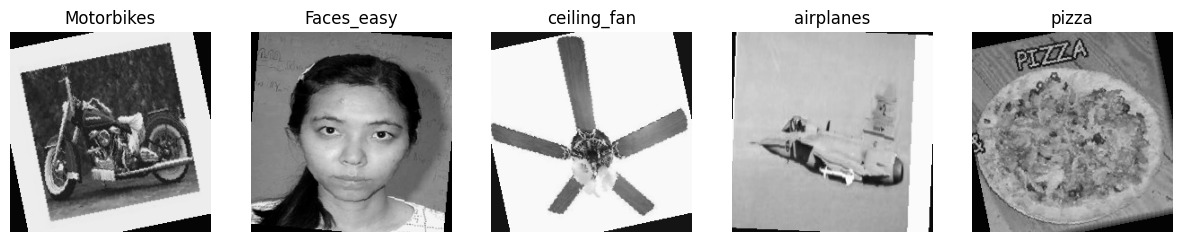

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 배치에서 하나 가져오기
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 클래스별로 하나의 샘플을 저장할 딕셔너리
sample_images = {}
sample_labels = {}

# 배치 내에서 최대 5개의 클래스만 선택
for img, label in zip(images, labels):
    label = label.item()  # Tensor -> 정수
    if label not in sample_images:  # 해당 클래스가 아직 추가되지 않았다면 저장
        sample_images[label] = img
        sample_labels[label] = dataset.classes[label]  # 클래스 이름 저장
    if len(sample_images) == 5:  # 최대 5개의 클래스만 선택
        break

# 시각화
num_classes = len(sample_images)
fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))  # 가로 크기 조정

if num_classes == 1:
    axes = [axes]  # 하나만 있을 경우 리스트로 변환

for ax, (label, img) in zip(axes, sample_images.items()):
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    img = (img * 0.5) + 0.5  # Normalize를 되돌리기
    img = np.clip(img, 0, 1)  # 값 범위 조정

    ax.imshow(img)
    ax.set_title(sample_labels[label])
    ax.axis("off")

plt.show()

## model define

In [ ]:
# Squeeze-and-Excitation 블록
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ResNet BasicBlock (기본 블록에 SEBlock 추가)
class SeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SeBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # SEBlock 적용
        out += self.shortcut(x)  # 잔차 연결
        out = self.relu(out)
        return out

# SeNet 모델 정의
class SeNet(nn.Module):
    def __init__(self, num_classes, block=SeBasicBlock, num_blocks=[2, 2, 2, 2], reduction=16):
        super(SeNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet의 여러 레이어 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, reduction=reduction)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, reduction=reduction)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, reduction):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, reduction))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, reduction=reduction))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
# ResNet BasicBlock (잔차 연결만 있는 기본 블록)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # 잔차 연결
        out = self.relu(out)
        return out

# ResNet 모델 정의
class ResNet(nn.Module):
    def __init__(self, num_classes, block=BasicBlock, num_blocks=[2, 2, 2, 2]):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet의 여러 레이어 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


## model train, test 함수 정의

In [ ]:
# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # 검증 단계
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

    return train_losses, val_losses, train_accs, val_accs




In [ ]:
senet = SeNet(101).to(device)
resnet = ResNet(101).to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer_senet = optim.Adam(senet.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

# 🔥 Learning Rate Scheduler 추가
scheduler_senet = optim.lr_scheduler.StepLR(optimizer_senet, step_size=5, gamma=0.5)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.5)

In [ ]:
# 테스트 함수
def test_model(model, test_loader, criterion, device="cpu"):
    model.to(device)
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss /= test_total  # 평균 손실
    test_acc = 100 * test_correct / test_total  # 정확도 계산
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    return test_loss, test_acc

## 학습 결과 시각화 함수

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

## model train

Training SeNet...
Epoch [1/30] - Train Loss: 3.7057, Train Acc: 22.66%
Validation Loss: 3.2458, Validation Accuracy: 29.82%

Epoch [2/30] - Train Loss: 2.9706, Train Acc: 33.95%
Validation Loss: 2.7599, Validation Accuracy: 38.66%

Epoch [3/30] - Train Loss: 2.5247, Train Acc: 41.56%
Validation Loss: 2.6475, Validation Accuracy: 39.97%

Epoch [4/30] - Train Loss: 2.1724, Train Acc: 47.82%
Validation Loss: 2.2870, Validation Accuracy: 46.50%

Epoch [5/30] - Train Loss: 1.9042, Train Acc: 52.45%
Validation Loss: 2.1458, Validation Accuracy: 49.12%

Epoch [6/30] - Train Loss: 1.6811, Train Acc: 57.88%
Validation Loss: 1.7771, Validation Accuracy: 55.88%

Epoch [7/30] - Train Loss: 1.4810, Train Acc: 61.50%
Validation Loss: 1.7219, Validation Accuracy: 56.96%

Epoch [8/30] - Train Loss: 1.3218, Train Acc: 64.96%
Validation Loss: 1.6515, Validation Accuracy: 58.34%

Epoch [9/30] - Train Loss: 1.1505, Train Acc: 68.58%
Validation Loss: 1.5752, Validation Accuracy: 61.26%

Epoch [10/30] - Tra

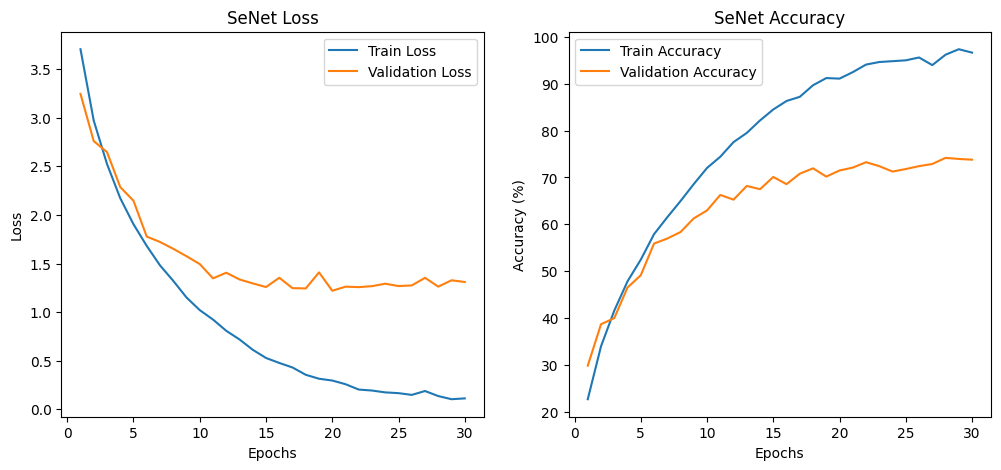

Training ResNet...
Epoch [1/30] - Train Loss: 3.8139, Train Acc: 22.56%
Validation Loss: 3.5023, Validation Accuracy: 28.90%

Epoch [2/30] - Train Loss: 3.0231, Train Acc: 34.56%
Validation Loss: 2.8146, Validation Accuracy: 39.35%

Epoch [3/30] - Train Loss: 2.5674, Train Acc: 41.20%
Validation Loss: 2.5130, Validation Accuracy: 42.74%

Epoch [4/30] - Train Loss: 2.1918, Train Acc: 47.72%
Validation Loss: 2.3799, Validation Accuracy: 43.35%

Epoch [5/30] - Train Loss: 1.9683, Train Acc: 51.77%
Validation Loss: 2.3111, Validation Accuracy: 47.19%

Epoch [6/30] - Train Loss: 1.7222, Train Acc: 56.68%
Validation Loss: 1.7844, Validation Accuracy: 57.26%

Epoch [7/30] - Train Loss: 1.5369, Train Acc: 60.99%
Validation Loss: 1.7884, Validation Accuracy: 56.03%

Epoch [8/30] - Train Loss: 1.3888, Train Acc: 63.92%
Validation Loss: 1.7244, Validation Accuracy: 58.03%

Epoch [9/30] - Train Loss: 1.2223, Train Acc: 67.76%
Validation Loss: 1.4197, Validation Accuracy: 64.26%

Epoch [10/30] - Tr

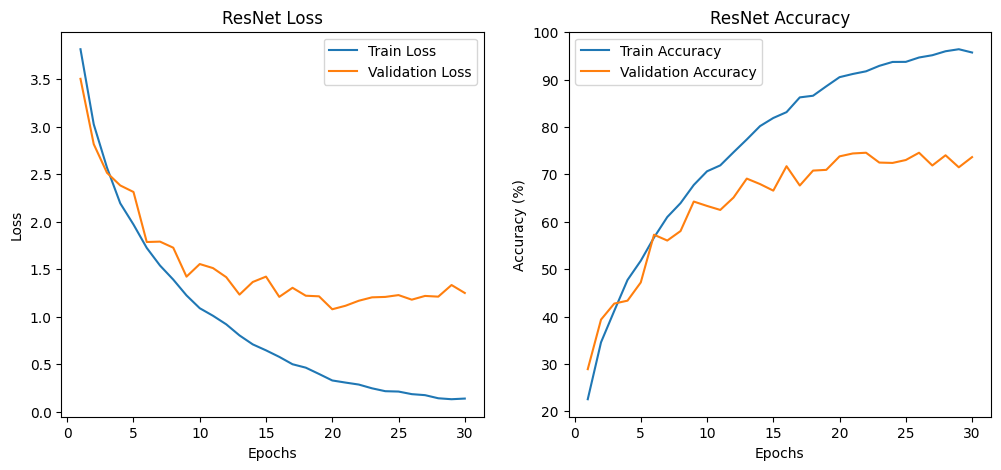

In [ ]:
# SeNet 학습
print("Training SeNet...")
senet_train_losses, senet_val_losses, senet_train_accs, senet_val_accs = train_model(
    senet, train_loader, valid_loader, criterion, optimizer_senet, num_epochs=30, device=device)

plot_metrics(senet_train_losses, senet_val_losses, senet_train_accs, senet_val_accs, "SeNet")

# ResNet 학습
print("Training ResNet...")
resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs = train_model(
    resnet, train_loader, valid_loader, criterion, optimizer_resnet, num_epochs=30, device=device)

plot_metrics(resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs, "ResNet")


## Test accuracy

In [54]:
# SeNet 테스트
print("Testing SeNet...")
senet_test_loss, senet_test_acc = test_model(senet, test_loader, criterion, device)


# ResNet 테스트
print("Testing ResNet...")
resnet_test_loss, resnet_test_acc = test_model(resnet, test_loader, criterion, device)


Testing SeNet...
Test Loss: 1.3762, Test Accuracy: 70.99%
Testing ResNet...
Test Loss: 1.3934, Test Accuracy: 71.30%


## 분석 및 고찰

### 결과
- 두 모델 다 train loss가 초반에 급격하게 줄면서 잘 수렴하고 있으므로 전체적으로 학습이 잘 이루어짐
- 또한 train loss가 증가하지 않고 계속 감소하므로 epoch를 30 이상으로 하면 더 좋은 성능을 낼 가능성의 여지가 있음
- 두 모델 다 전체적으로 test acc가 앞선 아키텍처에 비해 전체적으로 높음  


### SeNet > ResNet인 이유
- 성능 차이가 크진 않지만 SeNet이 약간 더 좋은 성능을 보임
- SeNet은 Squeeze-and-Excitation 모듈이 추가되어 각 채널의 중요도를 학습해 더 중요한 특징은 강조, 덜 중요한 특징은 줄이는 효과를 낸다

### 다른 아키텍처에 비해 ResNet 기반이 성능이 좋은 이유
- layer를 많이 쌓아 깊은 네트워크로 안정적으로 학습할 수 있는 구조적인 특징이 가장 큰 이유라고 생각
  - 네트워크가 깊어지면 강력한 표현력을 얻을 수 있음
- residual connection 덕분에 gradient vanishing의 문제를 해결할 수 있었음